In [33]:
!pip install pydot graphviz
!tensorboard --logdir=logs/model_visualization


^C


In [1]:
import numpy as np
import yfinance as yf
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform

# Function to fetch stock data from yfinance
def fetch_stock_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    data = data.fillna(method='ffill')  # Fill missing data
    return data

# Function to compute correlation matrix and clusters
def create_hyperedges_from_correlation(stock_data, num_clusters):
    returns = stock_data.pct_change().dropna()  # Compute daily returns
    correlation_matrix = returns.corr()  # Correlation matrix of returns

    # Convert correlation matrix to distance matrix (1 - correlation)
    distance_matrix = 1 - correlation_matrix

    # Perform hierarchical clustering to group similar stocks into hyperedges
    clustering = AgglomerativeClustering(n_clusters=num_clusters, affinity='precomputed', linkage='average')
    labels = clustering.fit_predict(distance_matrix)

    # Create incidence matrix based on clustering
    num_tickers = len(stock_data.columns)
    H = np.zeros((num_tickers, num_clusters))

    for ticker_idx, cluster_label in enumerate(labels):
        H[ticker_idx, cluster_label] = 1  # Assign ticker to its cluster (hyperedge)

    return H, correlation_matrix

# Main function
def main():
    # Define tickers and date range
    tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA', 'NFLX']
    start_date = '2020-01-01'
    end_date = '2023-01-01'

    # Fetch stock data from yfinance
    stock_data = fetch_stock_data(tickers, start_date, end_date)

    # Generate hypergraph incidence matrix based on correlation
    num_clusters = 3  # Define how many hyperedges you want to generate
    H, correlation_matrix = create_hyperedges_from_correlation(stock_data, num_clusters)

    print("Hypergraph Incidence Matrix (H):")
    print(H)
    print("Correlation Matrix:")
    print(correlation_matrix)

if __name__ == "__main__":
    main()


[*********************100%%**********************]  6 of 6 completed
C:\Users\Hamza\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Hypergraph Incidence Matrix (H):
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
Correlation Matrix:
Ticker      AAPL      AMZN      GOOG      MSFT      NFLX      TSLA
Ticker                                                            
AAPL    1.000000  0.663193  0.727659  0.811363  0.485514  0.519400
AMZN    0.663193  1.000000  0.683297  0.701370  0.592819  0.477203
GOOG    0.727659  0.683297  1.000000  0.825172  0.501709  0.452960
MSFT    0.811363  0.701370  0.825172  1.000000  0.507628  0.500853
NFLX    0.485514  0.592819  0.501709  0.507628  1.000000  0.408418
TSLA    0.519400  0.477203  0.452960  0.500853  0.408418  1.000000


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model

# Function to calculate returns from stock data
def calculate_returns(stock_data):
    return (stock_data[1:].values - stock_data[:-1].values) / stock_data[:-1].values

# Hypergraph GCN Model with embedded GRU
class HypergraphGRUModel(Model):
    def __init__(self, num_tickers, gru_units, num_clusters):
        super(HypergraphGRUModel, self).__init__()
        self.gru = layers.GRU(gru_units, return_sequences=True)  # GRU layer to process time series data
        self.dense = layers.Dense(num_tickers)  # Dense layer to project GRU output to ticker space
        self.num_clusters = num_clusters
        self.final_dense = layers.Dense(num_tickers)  # Additional dense layer to project back to ticker space
    
    def call(self, inputs, incidence_matrix):
        # inputs: shape = [batch_size, time_steps, num_tickers]
        # incidence_matrix: shape = [num_tickers, num_clusters]
        
        # Step 1: Process temporal data using GRU
        x = self.gru(inputs)  # Output shape: [batch_size, time_steps, gru_units]
        
        # Step 2: Apply Dense layer to project GRU output to the ticker space
        x = self.dense(x)  # Output shape: [batch_size, time_steps, num_tickers]
        
        # Step 3: Apply hypergraph convolution using the incidence matrix
        # Hypergraph convolution: x @ H (x is [batch_size, time_steps, num_tickers], H is [num_tickers, num_clusters])
        x = tf.einsum('bti,ic->btc', x, incidence_matrix)  # Output shape: [batch_size, time_steps, num_clusters]
        
        # Step 4: Project the data back to the original ticker space
        x = self.final_dense(x)  # Output shape: [batch_size, time_steps, num_tickers]
        
        return x  # Predicted returns for each ticker
    
# Test function with RMSE calculation
def test_model_with_hypergraph(model, stock_data, incidence_matrix):
    time_steps = stock_data.shape[0] - 1
    current_features = stock_data[:-1].values.reshape(1, time_steps, stock_data.shape[1])  # Shape: [1, time_steps, num_tickers]
    next_day_returns = calculate_returns(stock_data).reshape(1, time_steps, stock_data.shape[1])

    # Make predictions using the trained model
    predictions = model(current_features, incidence_matrix)
    
    # Calculate the RMSE
    mse_loss = tf.keras.losses.MeanSquaredError()
    test_mse = mse_loss(next_day_returns, predictions)
    
    # Root Mean Squared Error
    test_rmse = tf.sqrt(test_mse)
    
    print(f"Test RMSE: {test_rmse.numpy()}")

# Placeholder function for fetching stock data (using yfinance or another library)
def fetch_stock_data(tickers, start_date, end_date):
    import yfinance as yf
    return yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Main function to test the model
def main():
    # Define tickers and date range
    tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA', 'NFLX']
    start_date = '2020-01-01'
    end_date = '2023-01-01'

    # Fetch stock data from yfinance
    stock_data = fetch_stock_data(tickers, start_date, end_date)

    # Use the hypergraph incidence matrix (H) you generated earlier
    num_clusters = 3  # Based on your previous output
    H = np.array([[1., 0., 0.],
                  [1., 0., 0.],
                  [1., 0., 0.],
                  [1., 0., 0.],
                  [0., 0., 1.],
                  [0., 1., 0.]])

    # Define and compile the model (training should happen separately)
    num_tickers = len(tickers)
    gru_units = 64  # Number of units in the GRU layer (tunable)
    model = HypergraphGRUModel(num_tickers=num_tickers, gru_units=gru_units, num_clusters=num_clusters)

    # Test the model
    test_model_with_hypergraph(model, stock_data, H)

if __name__ == "__main__":
    main()


[*********************100%%**********************]  6 of 6 completed


Test RMSE: 0.9894418716430664


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import plot_model

# Function to calculate returns from stock data
def calculate_returns(stock_data):
    return (stock_data[1:].values - stock_data[:-1].values) / stock_data[:-1].values

# Hypergraph GCN Model with embedded GRU
class HypergraphGRUModel(Model):
    def __init__(self, num_tickers, gru_units, num_clusters):
        super(HypergraphGRUModel, self).__init__()
        self.gru = layers.GRU(gru_units, return_sequences=True, name="GRU_Layer")  # GRU layer to process time series data
        self.dense_tickers = layers.Dense(num_tickers, name="Dense_Ticker_Projection")  # Dense layer to project GRU output to ticker space
        self.dense_clusters = layers.Dense(num_clusters, name="Dense_Cluster_Projection")  # Dense layer to project to cluster space
        self.output_tickers = layers.Dense(num_tickers, name="Output_Ticker_Projection")  # Final output layer to match original number of tickers
        self.num_clusters = num_clusters
        self.incidence_matrix = self.add_weight(shape=(num_tickers, num_clusters),
                                                initializer="random_normal",
                                                trainable=False,
                                                name="incidence_matrix")
    
    def call(self, inputs):
        # inputs: shape = [batch_size, time_steps, num_tickers]
        # incidence_matrix: shape = [num_tickers, num_clusters]
        
        # Step 1: Process temporal data using GRU
        x = self.gru(inputs)  # Output shape: [batch_size, time_steps, gru_units]
        
        # Step 2: Apply Dense layer to project GRU output to the ticker space
        x = self.dense_tickers(x)  # Output shape: [batch_size, time_steps, num_tickers]
        
        # Step 3: Apply hypergraph convolution using the incidence matrix
        x = tf.einsum('bti,ic->btc', x, self.incidence_matrix)  # Output shape: [batch_size, time_steps, num_clusters]
        
        # Step 4: Apply final Dense layer to project back to the ticker space
        x = self.output_tickers(x)  # Output shape: [batch_size, time_steps, num_tickers]
        
        return x  # Predicted returns for each ticker

# Test function with RMSE calculation
def test_model_with_hypergraph(model, stock_data):
    time_steps = stock_data.shape[0] - 1
    current_features = stock_data[:-1].values.reshape(1, time_steps, stock_data.shape[1])  # Shape: [1, time_steps, num_tickers]
    next_day_returns = calculate_returns(stock_data).reshape(1, time_steps, stock_data.shape[1])

    # Make predictions using the trained model
    predictions = model(current_features)
    
    # Calculate the RMSE
    mse_loss = tf.keras.losses.MeanSquaredError()
    test_mse = mse_loss(next_day_returns, predictions)
    
    # Root Mean Squared Error
    test_rmse = tf.sqrt(test_mse)
    
    print(f"Test RMSE: {test_rmse.numpy()}")

# Main function to test and visualize the model
def main():
    # Define tickers and date range
    tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA', 'NFLX']
    start_date = '2020-01-01'
    end_date = '2023-01-01'

    # Fetch stock data from yfinance (placeholder function)
    stock_data = fetch_stock_data(tickers, start_date, end_date)

    # Use the hypergraph incidence matrix (H) you generated earlier
    num_clusters = 3  # Based on your previous output
    H = np.array([[1., 0., 0.],
                  [1., 0., 0.],
                  [1., 0., 0.],
                  [1., 0., 0.],
                  [0., 0., 1.],
                  [0., 1., 0.]])

    # Define and compile the model (training should happen separately)
    num_tickers = len(tickers)
    gru_units = 64  # Number of units in the GRU layer (tunable)
    model = HypergraphGRUModel(num_tickers=num_tickers, gru_units=gru_units, num_clusters=num_clusters)

    # Set the incidence matrix as the precomputed matrix H
    model.incidence_matrix.assign(H)

    # Manually build the model by specifying the input shape (batch_size, time_steps, num_tickers)
    model.build(input_shape=(None, stock_data.shape[0] - 1, num_tickers))

    # Visualize the model structure
    plot_model(model, to_file="hypergraph_gru_model.png", show_shapes=True, show_layer_names=True)

    # Test the model
    test_model_with_hypergraph(model, stock_data)

if __name__ == "__main__":
    main()


[*********************100%%**********************]  6 of 6 completed

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.



C:\Users\Hamza\anaconda3\Lib\site-packages\keras\src\layers\layer.py:372: UserWarning: `build()` was called on layer 'hypergraph_gru_model_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Test RMSE: 1.0036389827728271


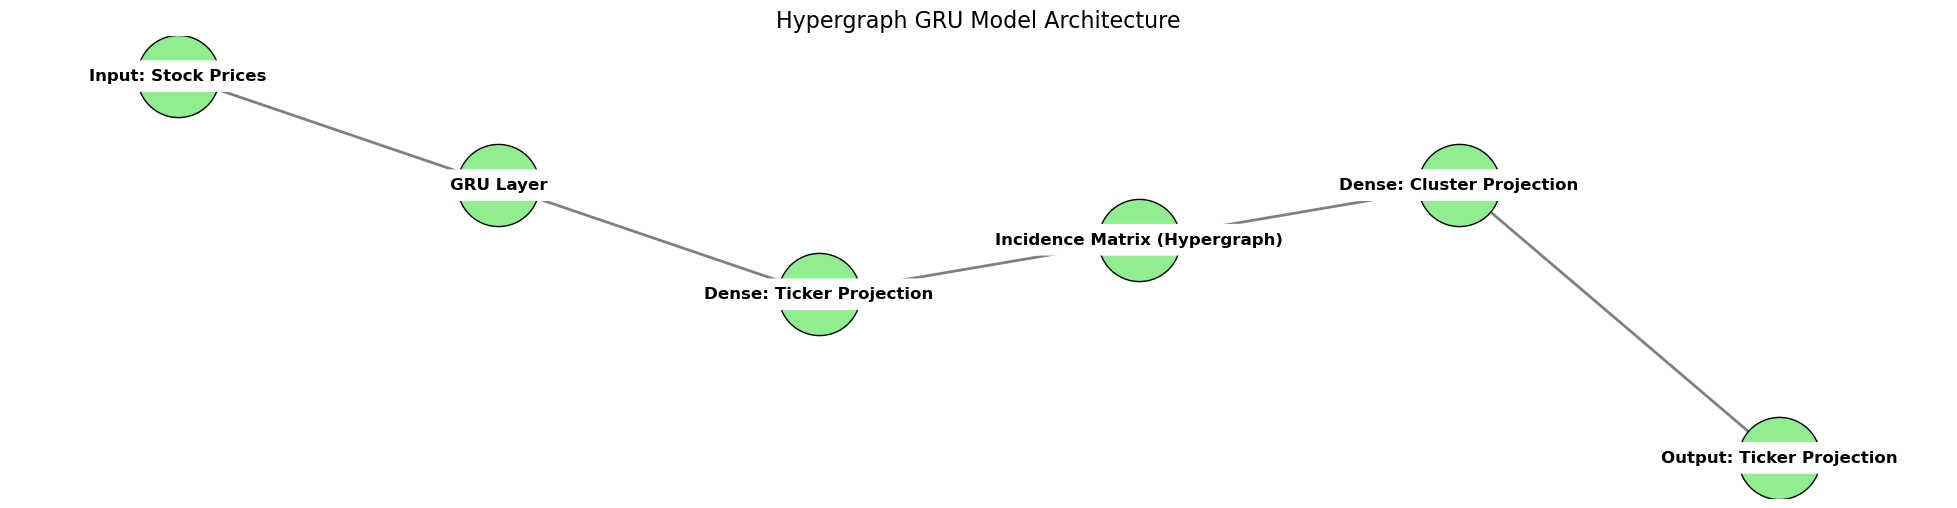

In [7]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a function to visualize the correct architecture
def plot_hypergraph_gru_model_correct():
    G = nx.DiGraph()
    
    # Add nodes representing layers in the correct flow
    G.add_node("Input: Stock Prices", pos=(0, 7))
    G.add_node("GRU Layer", pos=(1, 5))
    G.add_node("Dense: Ticker Projection", pos=(2, 3))
    G.add_node("Incidence Matrix (Hypergraph)", pos=(3, 4))  # Place incidence matrix slightly lower
    G.add_node("Dense: Cluster Projection", pos=(4, 5))
    G.add_node("Output: Ticker Projection", pos=(5, 0))  # Final output in ticker space
    
    # Add edges representing the flow of data between layers
    G.add_edges_from([
        ("Input: Stock Prices", "GRU Layer"),
        ("GRU Layer", "Dense: Ticker Projection"),
        ("Dense: Ticker Projection", "Incidence Matrix (Hypergraph)"),
        ("Incidence Matrix (Hypergraph)", "Dense: Cluster Projection"),
        ("Dense: Cluster Projection", "Output: Ticker Projection")
    ])
    
    # Get positions
    pos = nx.get_node_attributes(G, 'pos')
    
    # Plot the graph with better node sizes and edge arrows
    plt.figure(figsize=(25, 6))
    nx.draw_networkx_nodes(G, pos, node_size=3500, node_color="lightgreen", edgecolors="black")
    nx.draw_networkx_edges(G, pos, edge_color="gray", arrows=True, arrowsize=20, width=2)
    nx.draw_networkx_labels(G, pos, font_size=12, font_color="black", font_weight="bold", bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5'))
    
    # Set the title
    plt.title("Hypergraph GRU Model Architecture", size=16)
    plt.axis("off")
    
    # Show the plot
    plt.show()

# Call the corrected plotting function
plot_hypergraph_gru_model_correct()
